In [1]:
"""
Importing all the required packages
Python version used: 3.10.4
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.metrics import mean_squared_error, structural_similarity
import pandas as pd
from skimage.restoration import denoise_wavelet
from scipy.ndimage import median_filter, uniform_filter
from skimage import io


# Image reading and displaying

In [2]:
"""
This is a custom implementation built for reading a PGM image 
and returning pixel data as numpy array.

The function takes in filepath of PGM images in string as parameter and 
returns a numpy array of pixel data

Reference:
PGM format documentation - "PGM (Portable Gray Map) file format." Netpbm. [Online]. 
Available: https://netpbm.sourceforge.net/doc/pgm.html
[Accessed: 11-12-2024].
"""

def readImage(pgmFilePath):
    
    # Creating variables to store values
    magicNumber= None
    width = None
    height = None
    maxValue = None
    headersParsed = False
    headersFound = 0
    PixelValuesStart = 0

    # opening image as file in binary format and storing the contents in a variable
    with open(pgmFilePath,"rb") as imageContents:
        contents = imageContents.readlines()
        
    #This variable will be used to get the pixel data starting
    i=0
    
    # Iterating through the contents
    while i<len(contents):
        line=contents[i]
        lineStr = line.strip()

        # Getting all headers
        if not headersParsed:
            # Checking for comments
            if lineStr.startswith(b'#'): 
                i+=1
                continue   
            else:
                tokens = lineStr.split()
                for token in tokens:
                    textValue = token.decode()
                    # Getting magic number 
                    if magicNumber is None:
                        magicNumber = textValue
                        headersFound+=1
                    # Getting Width
                    elif width is None:
                        if textValue.isdigit():
                            width = int(textValue)
                            headersFound+=1
                        else:
                            raise ValueError("Width expected, got a non dight token")
                    # Getting Height   
                    elif height is None:
                        if textValue.isdigit():
                            height = int(textValue)
                            headersFound+=1
                        else: 
                            raise ValueError("Height expected, got non dight token")
                    # Getting Max Value
                    elif maxValue is None:
                         if textValue.isdigit():
                            maxValue = int(textValue)
                            headersFound+=1
                         else: 
                            raise ValueError("Max Value expected, got non dight token")
                    # Ending the loop if all headers are found
                    if headersFound == 4:
                        headersParsed = True
                        PixelValuesStart = i + 1
        else:
            pass    
            
        i+=1
    # Handling possible errors    
    if headersFound<4:
        raise ValueError("All the essential headers required for reading an image is not present hence this file cannot be opened")

    # Based on the Max Value, data type of the output array is set either to 8 bits or 16 bits
    dataType = np.uint8 if maxValue < 256 else np.uint16

    # If magic number is P5 
    if magicNumber == "P5":
        pixelData = b"".join(contents[PixelValuesStart:])
        #Using frombuffer to convert binary data to nunerical
        pixels = np.frombuffer(pixelData, dtype=dataType)
        imageArray = pixels.reshape(height, width)
        
        return imageArray
        
    # If magc number is P2
    if magicNumber == "P2":
        pixelData = " ".join(line.decode().strip() for line in contents[PixelValuesStart:])
        # Since the data is in ASCII format, directly using it
        pixels = list(map(int, pixelData.split()))
        imageArray = np.array(pixels, dtype=dataType).reshape(height, width)
  
        return imageArray
    
    else: 
        raise ValueError(" Magic number might be invalid")
        
 

In [3]:
"""
This function displays the images using matplot imshow library call

The function takes in numpy array of the pixel data as parameter and outputs the image

References: NA
"""

def displayImage(imageName):
    plt.imshow(imageName, cmap='gray')
    plt.show()


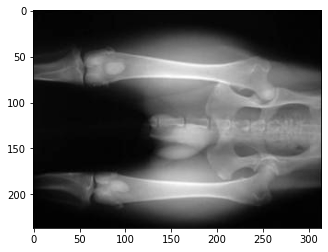

In [4]:
image = readImage("Dataset/original/dogbone.pgm")
displayImage(image)

# Wavelet decomposition and reconstruction

In [5]:
"""
This function is a custom implementation of Forward Discrete Wavelet Transform (FDWT) using Haar filter coeffecient

The function takes in 2d-numpy array and number of levels to decompose as input and returns a dictonary of wavelet coefficients at each level.
Structure of the output:
{
    1: {
        'Average': numpy.ndarray,      # Average coefficients (horizontal decomposition)
        'Difference': numpy.ndarray,   # Difference coefficients (horizontal decomposition)
        'LL': numpy.ndarray,           # Approximation coefficients (Low-Low)
        'LH': numpy.ndarray,           # Horizontal detail coefficients (Low-High)
        'HL': numpy.ndarray,           # Vertical detail coefficients (High-Low)
        'HH': numpy.ndarray            # Diagonal detail coefficients (High-High)
    },
    ...
    n: {
        'Average': numpy.ndarray,
        'Difference': numpy.ndarray,
        'LL': numpy.ndarray,
        'LH': numpy.ndarray,
        'HL': numpy.ndarray,
        'HH': numpy.ndarray,
        'originalShape': [int, int]   # Original image dimensions, only included at the last level
    }
}

Reference:
https://en.wikipedia.org/wiki/Discrete_wavelet_transform
[Accessed: 20-12-2024].
"""

def waveletDecompose(image,level):
    subBands = {}
    totalLevels = level
    originalRows, originalCols = image.shape
    if image.shape[0] % 2 != 0:
        image = np.pad(image, ((0, 1), (0, 0)), mode='constant', constant_values=0)
    if image.shape[1] % 2 != 0:
        image = np.pad(image, ((0, 0), (0, 1)), mode='constant', constant_values=0)

        
    #to prevent runtime overflow 
    matrixForProcessing = np.array(image, dtype=np.float64)
    while level!=0:
        
        #Horizontal Decompostion
        averageCoefficients = [] 
        differenceCoefficients = []
        for row in matrixForProcessing:
            if len(row) % 2 != 0:
                row = np.append(row, 0)  # Ensure even-length row
            averageCoefficients.append([(row[i]+row[i+1])/math.sqrt(2) for i in range(0,len(row),2)])
            differenceCoefficients.append([(row[i]-row[i+1])/math.sqrt(2) for i in range(0,len(row),2)])
        averageCoefficients = np.array(averageCoefficients)
        differenceCoefficients = np.array(differenceCoefficients)


        #vertical Decompostion
        LLT = [] 
        LHT = []
        HLT=[]
        HHT=[]
        # Transposing makes the calculation simple and consistant 
        averageCoefficientsT = averageCoefficients.T
        differenceCoefficientsT = differenceCoefficients.T
        
        for row in averageCoefficientsT:
            if len(row) % 2 != 0:
                row = np.append(row, 0)  # Ensure even-length column
            LLT.append([(row[i]+row[i+1])/math.sqrt(2) for i in range(0,len(row),2)])
            LHT.append([(row[i]-row[i+1])/math.sqrt(2) for i in range(0,len(row),2)])

        for row in differenceCoefficientsT:
            if len(row) % 2 != 0:
                row = np.append(row, 0)  # Ensure even-length column
            HLT.append([(row[i]+row[i+1])/math.sqrt(2) for i in range(0,len(row),2)])
            HHT.append([(row[i]-row[i+1])/math.sqrt(2) for i in range(0,len(row),2)])

        # Transposing it back
        LL = (np.array(LLT)).T
        LH = (np.array(LHT)).T
        HL = (np.array(HLT)).T
        HH = (np.array(HHT)).T
        
        # Writing decomposed band data to the output dictinory
        subBandLevel = totalLevels-level+1
        subBands[subBandLevel] = {}
        subBands[subBandLevel]['Average'] = averageCoefficients
        subBands[subBandLevel]['Difference'] = differenceCoefficients
        subBands[subBandLevel]['LL'] = LL
        subBands[subBandLevel]['LH'] = LH
        subBands[subBandLevel]['HL'] = HL
        subBands[subBandLevel]['HH'] = HH

        matrixForProcessing = LL
        level-=1
        
    # The below code is for removing padding if it was applied
    subBands[totalLevels]['originalShape'] = [originalRows, originalCols] 
    return subBands


In [6]:
""" 
This function implements the Inverse Discrete Wavelet Transform (IDWT) 
to reconstruct the image from it's wavelets coefficients

This function takes in dictionary of subband coefficients created by the above FDWT function
and returns an numpy array of the reconstructed image.

Reference:
https://en.wikipedia.org/wiki/Discrete_wavelet_transform
[Accessed: 25-12-2024].
"""

def imageReconstruction(subBandDict):
    level = list(subBandDict.keys())[-1]
    subBand = subBandDict[level]
    LL = subBand['LL']
    LH = subBand['LH']
    HL = subBand['HL']
    HH = subBand['HH']

    while level != 0:
        subBand = subBandDict[level]
        LH = subBand['LH']
        HL = subBand['HL']
        HH = subBand['HH']

        # Ensuring all subbands have the same shape
        maxRows = max(LL.shape[0], LH.shape[0], HL.shape[0], HH.shape[0])
        maxCols = max(LL.shape[1], LH.shape[1], HL.shape[1], HH.shape[1])

        LL = np.pad(LL, ((0, maxRows - LL.shape[0]), (0, maxCols - LL.shape[1])), mode='constant')
        LH = np.pad(LH, ((0, maxRows - LH.shape[0]), (0, maxCols - LH.shape[1])), mode='constant')
        HL = np.pad(HL, ((0, maxRows - HL.shape[0]), (0, maxCols - HL.shape[1])), mode='constant')
        HH = np.pad(HH, ((0, maxRows - HH.shape[0]), (0, maxCols - HH.shape[1])), mode='constant')

        averageCoefficients = []
        differenceCoefficients = []

        ## Vertical Reconstruction
        for i in range(len(LL)):
            averageCoefficients.append((LL[i] + LH[i]) / math.sqrt(2))
            averageCoefficients.append((LL[i] - LH[i]) / math.sqrt(2))
        for i in range(len(HL)):
            differenceCoefficients.append((HL[i] + HH[i]) / math.sqrt(2))
            differenceCoefficients.append((HL[i] - HH[i]) / math.sqrt(2))

        ## Horizontal Reconstruction
        reconstructedImage = []
        for i in range(len(averageCoefficients)):
            row = []
            for j in range(len(averageCoefficients[i])):
                pixel1 = (averageCoefficients[i][j] + differenceCoefficients[i][j]) / math.sqrt(2)
                pixel2 = (averageCoefficients[i][j] - differenceCoefficients[i][j]) / math.sqrt(2)
                row.extend([pixel1, pixel2])
            reconstructedImage.append(row)

        # Ensuring LL is a NumPy array
        LL = np.array(reconstructedImage)  
        level -= 1

    reconstructedImage = np.array(reconstructedImage)

    # Removing padding only if it was applied
    originalRows, originalCols = subBandDict[list(subBandDict.keys())[-1]]['originalShape']
    if reconstructedImage.shape[0] > originalRows or reconstructedImage.shape[1] > originalCols:
        reconstructedImage = reconstructedImage[:originalRows, :originalCols]
    
    return reconstructedImage


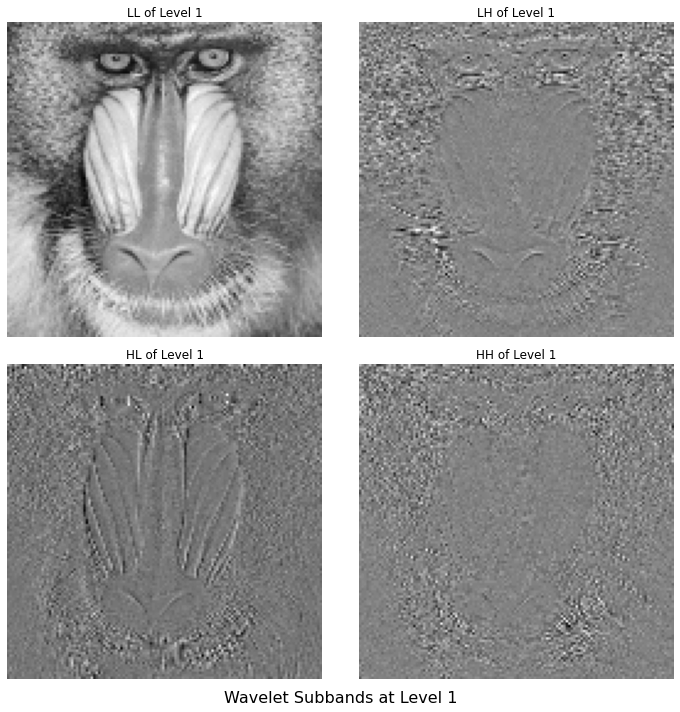

Mean Squared Error (Reconstruction): 1.2843742832785238e-26


In [7]:
"""
Testing FDWT function and inverse function
"""

# Testing FDWT function and inverse function
image = readImage("Dataset/original/mandrill.pgm")
levelsToDecompose = 3
subBands = waveletDecompose(image, levelsToDecompose)
re = imageReconstruction(subBands)


# Extracting subbands for level 1
ll = subBands[1]['LL']
lh = subBands[1]['LH']
hl = subBands[1]['HL']
hh = subBands[1]['HH']


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Displaying subbands with labels
axes[0, 0].imshow(ll, cmap='gray')
axes[0, 0].set_title("LL of Level 1", fontsize=12)
axes[0, 0].axis("off")

axes[0, 1].imshow(lh, cmap='gray')
axes[0, 1].set_title("LH of Level 1", fontsize=12)
axes[0, 1].axis("off")

axes[1, 0].imshow(hl, cmap='gray')
axes[1, 0].set_title("HL of Level 1", fontsize=12)
axes[1, 0].axis("off")

axes[1, 1].imshow(hh, cmap='gray')
axes[1, 1].set_title("HH of Level 1", fontsize=12)
axes[1, 1].axis("off")

fig.suptitle("Wavelet Subbands at Level 1", fontsize=16, y=0)
plt.tight_layout()
plt.show()

# MSE
mse = np.mean((re - image) ** 2)
print(f"Mean Squared Error (Reconstruction): {mse}")

# Image Denoising

In [8]:
"""
This function defines a manual median filter, which will be used as a pre processing step.

This function takes in image pixel values array as input and computes applies median filter to the image and returns
a NumPy array.

The kernalSize of 3 is chosen as it provided the best preprocessing results

Reference:
https://en.wikipedia.org/wiki/Median_filter
[Accessed: 29-12-2024].

"""

def preprocessingMedianFilter(image):
    kernalSize=3
    height, width = image.shape
    # Padding the image to handle borders
    paddedImage = np.pad(image,1)
    # Output image
    filteredValues = []

    # Applying medinan Filter
    for i in range(height):
        rowValues = []
        for j in range(width):
            # Extracting the neighborhood
            neighborhood = paddedImage[i:i + kernalSize, j:j + kernalSize]
            # Computing the median of the neighborhood
            medianValue = np.median(neighborhood)
            # Setting the median value to the output image
            rowValues.append(medianValue)
        filteredValues.append(rowValues)
    filteredImage = np.array(filteredValues, dtype=image.dtype)
    return filteredImage

In [9]:
"""
This function implements five thresholding techniques for denoising wavelet coefficients. 
These techniques are based on the methods discussed in the referenced paper. 

The function takes an array of wavelet coefficients to be thresholded and a specified thresholding 
method as inputs. It does computation of the appropriate thresholding and returns back an array.

Reference:
S. Ruikar and D. D. Doye, "Image denoising using wavelet transform," 
2010 International Conference on Mechanical and Electrical Technology, Singapore, 2010, 
pp. 509-515, doi: 10.1109/ICMET.2010.5598411. 
keywords: 
{Complexity theory;Image coding;Noise reduction;universashrink;baysshrink;sureshrink;normalshrink;vishushrink;etc},
[Accessed: 29-12-2024].

"""

def thresholding(valuesToThreshold, ThresholdingMethod):
    # Noise standard deviation
    sigma = np.median(np.abs(valuesToThreshold)) / 0.6745 

    # Computing the threshold based on the selected thresholding method
    if ThresholdingMethod == "universal":
        thresholdVal = sigma * np.sqrt(2 * np.log(valuesToThreshold.size))

    elif ThresholdingMethod == "VisuShrink":
        thresholdVal = sigma * np.sqrt(2 * np.log(valuesToThreshold.size))

    elif ThresholdingMethod == "sure":
        thresholdVal = min(np.sum(valuesToThreshold**2) / valuesToThreshold.size, sigma * np.sqrt(2 * np.log(valuesToThreshold.size)))

    elif ThresholdingMethod == "bayes":
        varSignal = max(np.var(valuesToThreshold) - sigma**2, 0)  # Signal variance
        thresholdVal = sigma**2 / np.sqrt(varSignal) if varSignal > 0 else sigma

    elif ThresholdingMethod == "normal":
        scaleParam = np.sqrt(np.mean(valuesToThreshold**2))  # Scale parameter
        thresholdVal = sigma**2 / scaleParam
        

    # Appling hybrid thresholding that combines soft and hard thresholding
    flatValues = valuesToThreshold.flatten()
    outputList = []

    # Applying thresholding element-wise
    for value in flatValues:
        if np.abs(value) > thresholdVal:
            # Applying soft thresholding
            outputList.append(value - np.sign(value) * thresholdVal / 2)
        else:
            # Setting to zero if below threshold
            outputList.append(0)

    # Converting the list back to a NumPy array and reshaping to original dimensions
    outputArray = np.array(outputList).reshape(valuesToThreshold.shape)
    
    return outputArray

In [10]:
"""
This function is used to compute Mean Squared Error (MSE) and Structural Similarity Index (SSIM) values

This function takes in two image data arrays and outputs 2 floating point numbers
"""
def computeMetrics(originalImage, denoisedImage):

    originalArray = np.array(originalImage)
    denoisedArray = np.array(denoisedImage)

    if originalArray.shape != denoisedArray.shape:
        raise ValueError("shape mismatch between original and noisy images")

    mseVal = mean_squared_error(originalArray, denoisedArray)
    ssimVal = structural_similarity(originalArray, denoisedArray, data_range=originalArray.max() - originalArray.min())
    
    return mseVal, ssimVal


In [11]:
"""
Main function for denoising an image using wavelet-based techniques.

It operates in two modes:
1. Without a original image: Uses the Universal Threshold for denoising.
2. With a original image: Compares different thresholding methods to identify the best based on 
   Mean Squared Error (MSE) and Structural Similarity Index (SSIM).

The function takes in the following as parameters
    filePath (str): Path to the noisy image to be denoised.
    originalFilePath (str, optional): Path to the original image. If not provided, the function defaults to using the Universal Threshold.
    levels (int): Number of wavelet decomposition levels. Default is 3 but can be adjusted.

The function returns a list containing the following elements
        - bestImage (ndarray): The denoised image.
        - bestMethod (str): The name of the best thresholding method used.
        - bestMse (float): The MSE value of the best denoised image.
        - bestSsim (float): The SSIM value of the best denoised image.
"""

def denoiseImage(filePath, originalFilePath=None, levels=3):
    # Read the noisy image
    noisyImage = readImage(filePath)

    # This is a custom preprocessing step that applies median filtering to the image before wavelet decomposition is applied
    noisyImage = preprocessingMedianFilter(noisyImage)

    # If ground truth is not present, proceeding with Universal Threshold
    if originalFilePath is None:
        subBandValues = waveletDecompose(noisyImage, levels)
        for level in range(levels, 0, -1):
            for band in ['LH', 'HL', 'HH']:
                coeffs = subBandValues[level][band]
                subBandValues[level][band] = thresholding(coeffs, method="universal")
        bestImage = imageReconstruction(subBandValues)
        bestMethod = "universal"
        return bestImage, bestMethod

    # Otherwise, comparing all thresholding methods using the ground truth
    originalImage = readImage(originalFilePath)

    ThresholdingMethods = ["universal", "VisuShrink", "sure", "bayes", "normal"]
    bestImage = None
    bestMethod = None
    bestMse = float('inf')
    bestSsim = -float('inf')

    for method in ThresholdingMethods:

        # Wavelet decomposition
        subBandValues = waveletDecompose(noisyImage, levels)

        # Applying thresholding for each subband
        for level in range(levels, 0, -1):
            for band in ['LH', 'HL', 'HH']:
                coeffs = subBandValues[level][band]
                subBandValues[level][band] = thresholding(coeffs, ThresholdingMethod=method)

        # Reconstructing the denoised image
        denoisedImage = imageReconstruction(subBandValues)
  
        # calculating metrics
        mseVal, ssimVal = computeMetrics(originalImage, denoisedImage)

        # Updating the best image if current is better
        if mseVal < bestMse or (mseVal == bestMse and ssimVal > bestSsim):
            bestMse = mseVal
            bestSsim = ssimVal
            bestImage = denoisedImage
            bestMethod = method

    return [bestImage, bestMethod , bestMse, bestSsim]


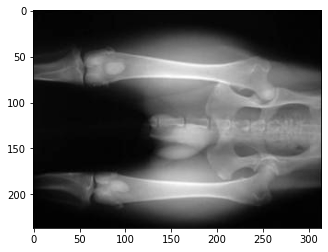

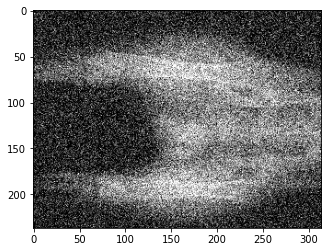

           Method           MSE      SSIM
0      VisuShrink  10733.845371  0.007621
1     BayesShrink  10732.973915  0.007552
2   Median Filter    518.071555  0.211531
3     Mean Filter    324.661520  0.303320
4  denoiseImage()    154.892163  0.576829


In [12]:
"""
The below code compares the custom denoising function with denoising library calls like BayesShrink, VisuShrink, Median Filter,
MeanFilter and Uniform Filter 
"""
# Loading the grayscale (PGM) image
noisyImage = readImage("Dataset/noisy_3/dogbone.pgm")
imageOriginal = readImage("Dataset/original/dogbone.pgm")


denoisedImageBayesShrink = denoise_wavelet(noisyImage,method='BayesShrink',mode='soft',channel_axis=None)

denoisedImageVisuShrink = denoise_wavelet(noisyImage,method='VisuShrink',mode='soft',channel_axis=None)

denoisedCustom = denoiseImage("Dataset/noisy_3/dogbone.pgm","Dataset/original/dogbone.pgm")

denoisedMedian = median_filter(noisyImage, size=3)

denoisedMean = uniform_filter(noisyImage,size=3)

#computing metrics
mseV,ssmiV = computeMetrics(imageOriginal,denoisedImageVisuShrink)
mseB,ssmiB = computeMetrics(imageOriginal,denoisedImageBayesShrink)
mseC,ssmiC = computeMetrics(imageOriginal,denoisedCustom[0])
mseMed,ssmiMed = computeMetrics(imageOriginal,denoisedMedian)
mseMean,ssmiMean = computeMetrics(imageOriginal,denoisedMean)

displayImage(imageOriginal)
displayImage(noisyImage)

results = {
    "Method": ["VisuShrink", "BayesShrink", "Median Filter", "Mean Filter", "denoiseImage()"],
    "MSE": [mseV, mseB, mseMed, mseMean, mseC],
    "SSIM": [ssmiV, ssmiB, ssmiMed, ssmiMean, ssmiC]
}

# Createing a DataFrame
resultsDf = pd.DataFrame(results)

# Displaying the DataFrame
print(resultsDf)

In [13]:
"""
This code chunk is used for testing and debugging purposes
This ensures that 
    - readImage function works fine for all images
    - FDWT and IDWT functions work fine for all images
    - denoiseImage() works fine for all images

Give noisy and original image folder paths in noisyDir and originalDir correctly before running this code
"""
# # Directories containing noisy and original images
# noisyDir = "Dataset/noisy_3/"
# originalDir = "Dataset/original/"

# # List all image files in the directories
# noisyImages = sorted(os.listdir(noisyDir))
# originalImages = sorted(os.listdir(originalDir))

# # Check if both directories have the same number of images
# if len(noisyImages) != len(originalImages):
#     raise ValueError("The number of noisy and original images does not match!")

# # Iterate through all image pairs
# for noisyImage, originalImage in zip(noisyImages, originalImages):
#     # Construct full paths
#     noisyPath = os.path.join(noisyDir, noisyImage)
#     originalPath = os.path.join(originalDir, originalImage)
    
#     # Read noisy and original images
#     noisy = readImage(noisyPath)
#     original = readImage(originalPath)

#     # Debugging: Ensure the images are loaded correctly
#     if noisy.shape != original.shape:
#         print(f"Error: Image shapes do not match for {noisyImage} and {originalImage}")
#         continue

#     # Test the denoising function
#     denoised = denoiseImage(noisyPath,originalPath)  # Ensure noisy image is passed here

#     # Debugging: Ensure denoised output is valid
#     if denoised[0].shape != original.shape:
#         print(f"Error: Shape mismatch in denoised output for {noisyImage}")
#         continue

#     # Computing metrics
#     meanSquaredError, structuralSimilarity = computeMetrics(original, denoised[0])

#     # Plotting images side by side
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(f"Image: {noisyImage} | Best Method: {denoised[1]}", fontsize=14, y=0.95)

#     # Original image
#     plt.subplot(1, 3, 1)
#     plt.imshow(original, cmap='gray')
#     plt.title("Original Image")
#     plt.axis("off")

#     # Noisy image
#     plt.subplot(1, 3, 2)
#     plt.imshow(noisy, cmap='gray')
#     plt.title("Noisy Image")
#     plt.axis("off")

#     # Denoised image
#     plt.subplot(1, 3, 3)
#     plt.imshow(denoised[0], cmap='gray')
#     plt.title("Denoised Image")
#     plt.axis("off")

#     # Displaying metrics below the images
#     plt.figtext(0.5, 0.01, f"MSE: {meanSquaredError:.4f} | SSIM: {structuralSimilarity:.4f}", ha="center", fontsize=12)
#     plt.tight_layout()
#     plt.show()


'\nThis code chunk is used for testing and debugging purposes\nThis ensures that \n    - readImage function works fine for all images\n    - FDWT and IDWT functions work fine for all images\n    - denoiseImage() works fine for all images\n\nGive noisy and original image folder paths in noisyDir and originalDir correctly before running this code\n'